In [8]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import io

In [9]:
#getting the original dataset
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2020-09-19 03:29:20--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 108.177.119.113, 108.177.119.138, 108.177.119.100, ...
Connecting to drive.google.com (drive.google.com)|108.177.119.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t8podjb8mvd0k93kt6hip5ht4vg172ge/1600486125000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2020-09-19 03:29:20--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t8podjb8mvd0k93kt6hip5ht4vg172ge/1600486125000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|1

In [10]:
#reading the dataset and extracting sentences and labels to work on
dataset = pd.read_csv('/tmp/sentiment.csv')

# Just extract out sentences and labels first - we will create subwords here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [17]:
#creating the subword dataset from amazon and yelp dataset
#tensorflow_datasets's SubwordTextEncoder functionality for creating dataset.
# SubwordTextEncoder.build_from_corpus() will create a tokenizer for us
#we can also use this for much larger corpus of texts
vocab_size = 1000
#tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(sentences,vocab_size, max_subword_length=5)

In [18]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


In [20]:
# replacing sentence data with encoded subwords
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [21]:
#checking if sentences are properly replaced
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


In [22]:
#Final preprocessing

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [23]:
#Training the sentiment model
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [24]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs=num_epochs, 
                    validation_data=(testing_sentences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5091 - val_loss: 0.6974 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5399 - val_loss: 0.6967 - val_accuracy: 0.4311
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6798 - accuracy: 0.5487 - val_loss: 0.6916 - val_accuracy: 0.4937
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6684 - accuracy: 0.6114 - val_loss: 0.6807 - val_accuracy: 0.5363
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6874 - val_loss: 0.6746 - val_accuracy: 0.5313
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.7037 - val_loss: 0.6493 - val_accuracy: 0.6416
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.5921 - accuracy: 0.7602 - val_loss: 0.6240 - val_accuracy: 0.6942
Epoch 8/30
50/50 [==

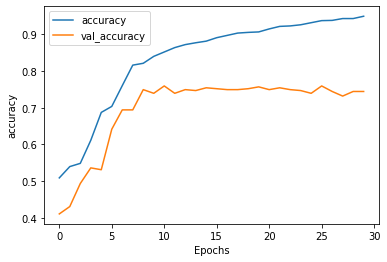

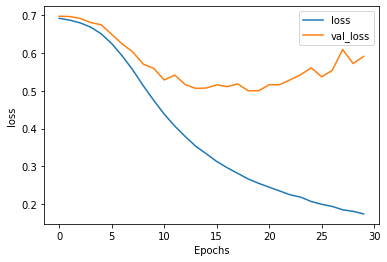

In [25]:
#vizualizing the graph


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [27]:
#it actually made the validation accurancy worse and there are clear signs of
# overfitting this is maybe because the model doesnot know the contexual meaning
# of sentences

#downloading the model for visualization

# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Write out the embedding vectors and metadata
out_v = io.open('vecs_subwords.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_subwords.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs_subwords.tsv')
  files.download('meta_subwords.tsv')

(1000, 16)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>